In [1]:
from models import GraphEmbedding
from data_utils import GraphSetDataset
import torch
from torch_geometric.data import Batch
import numpy as np

dataset = GraphSetDataset('data/hea_youngs.pkl')
result_path = 'results/att_score/'
model_checkpoint = 'results/checkpoints/GraphConv_2_h32_youngs.pt'

class SetsAttScore(torch.nn.Module):
    def __init__(self, n_node_features, gnn_dim, molsets_dim, conv, n_conv_layers, after_readout='tanh', activation='relu', norm=None):
        super().__init__()

        match activation:
            case 'relu': self.act = torch.nn.ReLU()
            case 'silu': self.act = torch.nn.SiLU()
            case 'gelu': self.act = torch.nn.GELU()
            case 'lrelu': self.act = torch.nn.LeakyReLU()
            case _: raise NotImplementedError
        
        emb_dim = n_node_features if conv == 'CGConv' else gnn_dim
        self.phi = GraphEmbedding(n_node_features, emb_dim, conv, n_conv_layers, after_readout, self.act, norm=norm)

        self.att_q_net = torch.nn.Linear(emb_dim, molsets_dim)
        self.att_k_net = torch.nn.Linear(emb_dim, molsets_dim)
        self.att_v_net = torch.nn.Linear(emb_dim, emb_dim)
        self.rho = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, molsets_dim),
            self.act,
            torch.nn.Linear(molsets_dim, molsets_dim),
            self.act,
            torch.nn.Linear(molsets_dim, 1)
        )

    def forward(self, graph_list):
        # graph_list is a batch of graphs in one datapoint
        embeddings = self.phi(graph_list)  # n_graphs * emb_dim

        frac = graph_list.y.unsqueeze(0)  # n_graphs * 1

        # Permutation-invariant aggregation using attention mechanism
        att_queries = self.att_q_net(embeddings)  # n_graphs * att_dim
        att_values = self.att_v_net(embeddings)  # n_graphs * emb_dim
        att_keys = self.att_k_net(embeddings)  # n_graphs * att_dim
        att_scores = torch.matmul(att_queries, att_keys.transpose(0, 1)) / (att_keys.size(1) ** 0.5) # n_graphs * n_graphs
        att_outputs = torch.matmul(torch.softmax(att_scores, dim=0), att_values) # n_graphs * emb_dim
        
        # Changed from here
        return torch.div(torch.norm(att_outputs, dim=1), torch.norm(embeddings, dim=1))  # n_graphs
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SetsAttScore(n_node_features=19, gnn_dim=32, molsets_dim=32, conv='GraphConv', n_conv_layers=2, after_readout='tanh', activation='relu', norm=None).to(device)

model.load_state_dict(torch.load(model_checkpoint))
scores = []
model.eval()

with torch.no_grad():
    for sample in dataset:
        inputs, target = sample
        inputs = [data.to(device) for data in inputs]
        inputs = Batch.from_data_list(inputs)
        out = model(inputs)
        scores.append(out.cpu().numpy())

scores = np.stack(scores, axis=0)

#%%
np.savetxt(result_path + 'att_scores_youngs.csv', scores, fmt='%.3f', delimiter=',')

Get compositions and youngs moduli

In [2]:
import json

result_path = 'results/att_score/'

with open('./data/hea_full.txt', 'r') as f:
    data = json.loads(f.read())

with open(result_path + 'comps.csv', 'w', newline='') as f:
    # writer = csv.writer(f, quoting=csv.QUOTE_NONE, escapechar='\\', delimiter=',')
    for dp in data:
        bm = dp['Bulk modulus']
        if bm < 0 or bm > 320:
            continue
        if 'Youngs modulus' in dp:
            youngs = dp['Youngs modulus']
            if youngs < 0 or youngs > 900:
                continue
            f.write(dp['Composition'].replace(' ', ',')+'\n')

Analytics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

result_path = 'results/att_score/'

comps = pd.read_csv(result_path + 'comps.csv', header=None)
scores = pd.read_csv(result_path + 'att_scores_youngs.csv', header=None)

select_triple = []
select_most = []
select_both = []
for i in range(1909):
    row = scores.loc[i]
    for j in range(3):
        if row[j] > 3*min(row):
            select_triple.append((i,j))
            if row[j] == max(row):
                select_both.append((i,j))
        if row[j] == max(row):
            select_most.append((i,j))

<BarContainer object of 15 artists>

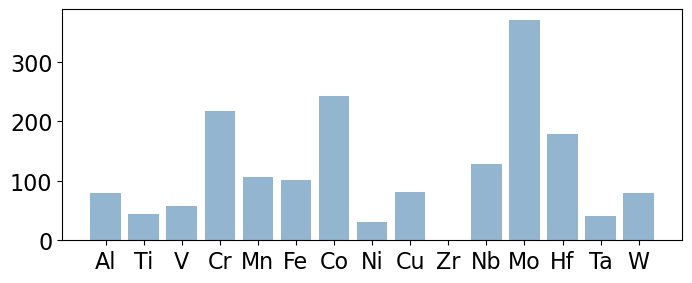

In [4]:
el_list = ['Al', 'Ti', 'V0', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zr', 'Nb', 'Mo', 'Hf', 'Ta', 'W0']
el_name_list = ['Al', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zr', 'Nb', 'Mo', 'Hf', 'Ta', 'W']

key_elements_triple = [comps.loc[i,j][0:2] for i,j in select_triple]

key_dict_triple = {el_name_list[i]:key_elements_triple.count(el) for i, el in enumerate(el_list)}
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(*zip(*key_dict_triple.items()), color='#93b5cf')

<BarContainer object of 15 artists>

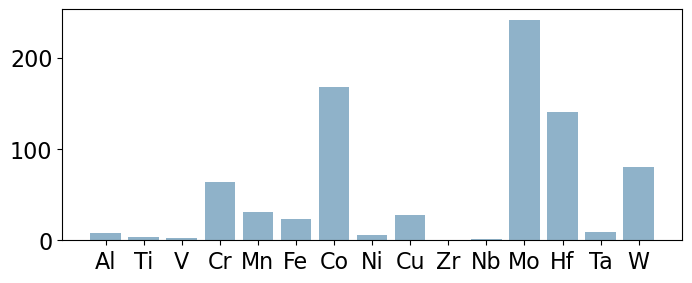

In [5]:
key_elements_both = [comps.loc[i,j][0:2] for i,j in select_both]

key_dict_both = {el_name_list[i]:key_elements_both.count(el) for i, el in enumerate(el_list)}
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(*zip(*key_dict_both.items()), color='#8fb2c9')

In [6]:
def find_scores_interact(el1, el2):
    scores_with_el2 = []
    scores_wo_el2 = []
    for i, row in comps.iterrows():
        row_els = [row[i][0:2] for i in range(4)]
        if el1 in row_els:
            row_score = scores.loc[i, row_els.index(el1)]
            if el2 in row_els:
                scores_with_el2.append(row_score)
            else:
                scores_wo_el2.append(row_score)
    if min(len(scores_with_el2), len(scores_wo_el2)) < 1:
        print(el1, el2)
        return 0, 0
    return np.mean(scores_with_el2), np.mean(scores_wo_el2)

interact_map = np.zeros((15, 15))

for i, el1 in enumerate(el_list):
    for j, el2 in enumerate(el_list):
        if i != j:
            score_with, score_wo = find_scores_interact(el1, el2)
            score_diff = score_with - score_wo
            interact_map[i,j] = score_diff

interactions = pd.DataFrame(interact_map, columns=el_name_list, index=el_name_list)

Co Ta
Ni Ta
Cu Ta
Hf Ta
Ta Co
Ta Ni
Ta Cu
Ta Hf


Text(78.25, 0.5, 'Element 1')

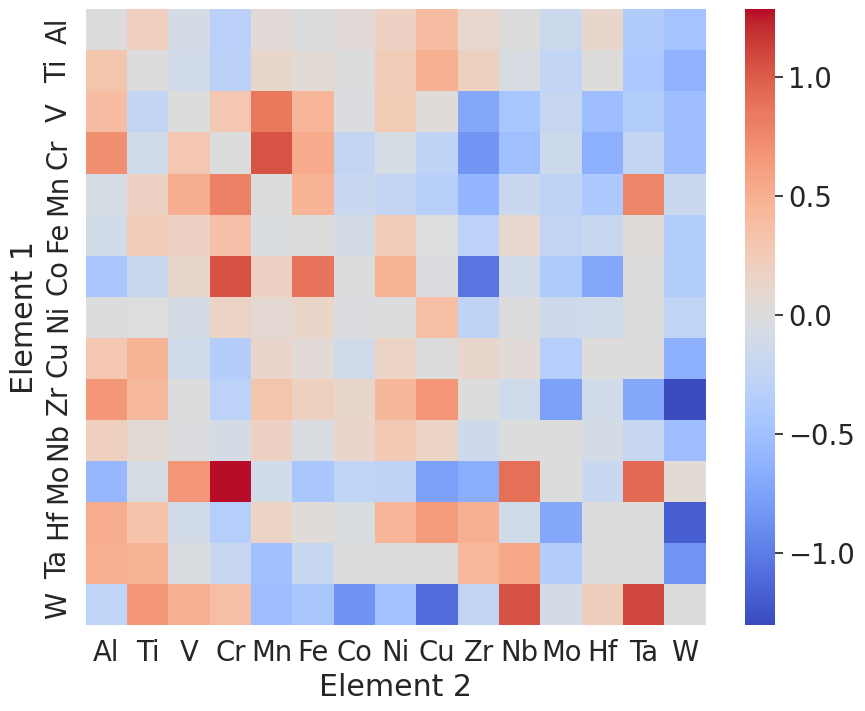

In [7]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.set_theme(font_scale=1.8)
sns.heatmap(interactions, cmap='coolwarm', center=0)
plt.xlabel('Element 2')
plt.ylabel('Element 1')